
# 1. Build an image segmentation model using pytorch

In [26]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
import os
from tqdm import tqdm
import torchvision.models as models
import torch
import torch.nn as nn
import torchvision.models as models
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import matplotlib.pyplot as plt



In [27]:
# Mounting drive
from google.colab import drive 
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [28]:
# Unzipping the dataset 

from zipfile import ZipFile
file_name = "/content/Drive/MyDrive/Colab Notebooks/Neural Network/Project 3/Lung_segmentation.zip"

with ZipFile(file_name,'r') as zip :
  zip.extractall()
  print('Complete')

Complete


In [29]:
#Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
# Decoder Block

class DecoderBlock(nn.Module):
    """Decoder Block of UNet architecture"""
    def __init__(self, in_channels, middle_channels, out_channels):
        """
        Initializes the DecoderBlock

        :param in_channels: Number of input channels
        :param middle_channels: Number of middle channels
        :param out_channels: Number of output channels
        """
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        """
        Implements the forward pass of the DecoderBlock

        :param x: Input tensor
        :return: Output tensor
        """
        return self.block(x)
 
# Model Architecture
class UNetResNet50(nn.Module):
    """UNet architecture with ResNet50 encoder"""
    def __init__(self, num_classes=1):
        """
        Initializes the UNetResNet50 model

        :param num_classes: Number of output classes
        """
        super().__init__()

        # Load pretrained ResNet50
        self.encoder = models.resnet50(pretrained=True)

        # Define other layers
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU(inplace=True)

        # Encoder blocks
        self.encoder1 = nn.Sequential(self.encoder.conv1, self.encoder.bn1, self.encoder.relu)
        self.encoder2 = nn.Sequential(self.pool, self.encoder.layer1)
        self.encoder3 = self.encoder.layer2
        self.encoder4 = self.encoder.layer3
        self.encoder5 = self.encoder.layer4

        # Decoder blocks and bridge
        self.center = DecoderBlock(2048, 2048, 1024)
        self.decoder5 = DecoderBlock(3072, 2048, 1024)
        self.decoder4 = DecoderBlock(2048, 1024, 512)
        self.decoder3 = DecoderBlock(1024, 512, 256)
        self.decoder2 = DecoderBlock(512, 256, 64)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        """
        Implements the forward pass of the UNetResNet50 model

        :param x: Input tensor
        :return: Output tensor
        """

        # Encoder
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        x5 = self.encoder5(x4)

        # Bridge
        c = self.center(self.pool(x5))

        # Decoder
        d5 = self.decoder5(torch.cat([c, x5], dim=1))
        d4 = self.decoder4(torch.cat([d5, x4], dim=1))
        d3 = self.decoder3(torch.cat([d4, x3], dim=1))
        d2 = self.decoder2(torch.cat([d3, x2], dim=1))
        d1 = self.decoder1(torch.cat([d2, x1], dim=1))

        return d1

In [31]:
# Custom Dataset loader
class LungDatasetLoader(Dataset):
    """
    Dataset loader for lung images and masks.
    """
    def __init__(self, img_dir, mask_dir, is_train, transform=None):
        """
        Initializes the dataset with paths and using the transform function.

        :param img_dir: Path to the image directory.
        :param mask_dir: Path to the mask directory.
        :param is_train: Whether the dataset is a training dataset or not.
        :param transform: Transform function to be applied to the images and masks.
        """
        self.img_dir_path = img_dir
        self.mask_dir_path = mask_dir
        self.is_train = is_train
        self.transform = transform

        # If training dataset, get all image and mask file paths and sort them
        # If validation dataset, get all image and mask file paths and sort them

        self.img_paths = [os.path.join(self.img_dir_path, f) for f in os.listdir(self.img_dir_path)]
        self.img_paths.sort()
        self.mask_paths = [os.path.join(self.mask_dir_path, f.replace('.jpg', '_mask.png')) for f in os.listdir(self.mask_dir_path)]
        self.mask_paths.sort()

    def __len__(self):
        """
        Returns the number of image files in the dataset.
        """
        return len(self.img_paths)

    def __getitem__(self, index):
        """
        Gets the image and mask paths for a given index, loads the image and mask using PIL library, applies the given
        transform to both the image and mask, and returns the transformed image and mask as tuple.

        :param index: Index of the image and mask to be loaded.
        :return: Tuple of transformed image and mask.
        """
        img_path = self.img_paths[index]
        mask_path = self.mask_paths[index]

        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask



In [62]:
# Define the transformations for training and test data
train_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.Grayscale(num_output_channels=3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=256),
    transforms.ToTensor()
])

In [63]:
# Define the dataset and dataloaders
img_dir = '/content/Train/Images'
mask_dir = '/content/Train/Masks'
batch_size = 16

# Define the train and test datasets
train_dataset = LungDatasetLoader(img_dir, mask_dir, is_train=True, transform=train_transform)
test_dataset = LungDatasetLoader(img_dir, mask_dir, is_train=False, transform=test_transform)

# Define the dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [64]:
images, masks = next(iter(train_dataloader))

images.size()

torch.Size([16, 3, 256, 256])

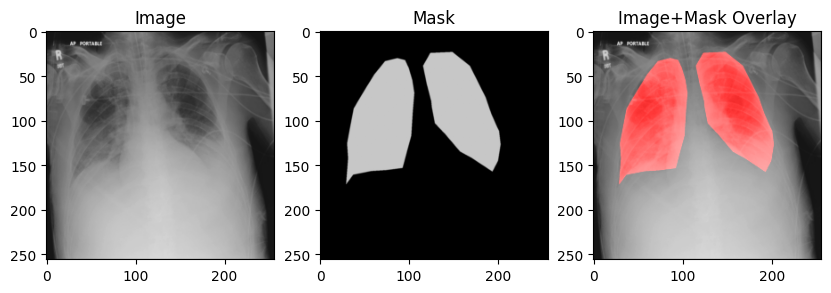

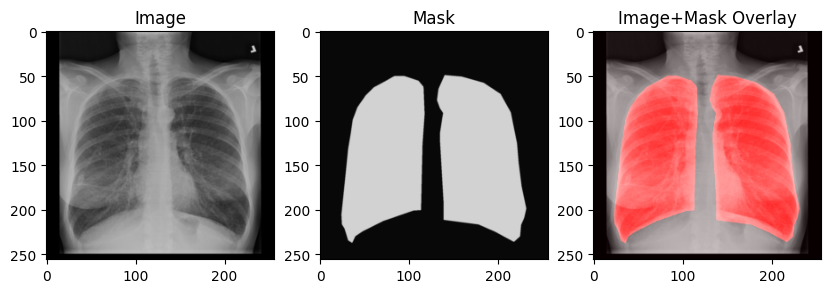

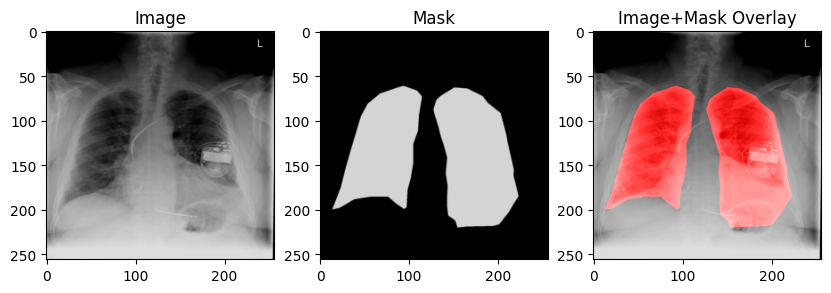

In [72]:

# Select 3 random batches from the train loader
num_batches = len(train_dataloader)
batch_indices = random.sample(range(num_batches), 3)

# Define color for overlay
overlay_color = [1.0, 0.0, 0.0] # Red color

# Plot each batch
for i, batch_idx in enumerate(batch_indices):
    # Get the batch
    images, masks = next(iter(train_dataloader))

    # Select a random index from the batch
    idx = random.randint(0, batch_size - 1)

    # Get the image and mask corresponding to the selected index
    image = images[idx].permute(1, 2, 0).cpu()
    mask = masks[idx].permute(1, 2, 0).cpu()

    # Overlay image and mask
    overlay = image.numpy() + overlay_color * mask.numpy()

    # Plot the image, mask, and overlay
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    ax1.imshow(image)
    ax2.imshow(mask, cmap='gray')
    ax3.imshow(overlay)
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Image+Mask Overlay')
    plt.show()


In [73]:
#Instantiating the model
model = UNetResNet50(num_classes=1).to(device)

In [107]:
# Training Function
def training(model, train_loader, criterion, optimizer, num_epochs, weight_decay=0):
  """
  Trains the model using the given dataloader, optimizer, and criterion.

  php
  Copy code
  :param model: PyTorch model to be trained.
  :param train_loader: DataLoader for the training dataset.
  :param criterion: Loss function for the model.
  :param optimizer: Optimizer used for the training process.
  :param num_epochs: Number of epochs for training the model.
  :param weight_decay: L2 regularization weight decay parameter.
  """
  train_loss = []
  train_acc = []
  best_loss = float('inf')

  for epoch in range(num_epochs):
      running_loss = 0.0
      running_accuracy = 0.0
      
      for images, masks in train_loader:
          # Move data to the device
          images = images.to(device)
          masks = masks.to(device)

          # Resize masks to match the output of the model
          masks = torch.nn.functional.interpolate(masks, size=(128, 128), mode='bilinear', align_corners=False)

          # Zero the optimizer gradient
          optimizer.zero_grad()

          # Forward pass
          outputs = model(images)

          # Convert masks to grayscale
          masks = torch.mean(masks, dim=1, keepdim=True)

          # Compute the loss
          loss = criterion(outputs, masks)

          # L2 regularization using weight decay
          if weight_decay > 0:
              l2_reg = torch.tensor(0.).to(device)
              for param in model.parameters():
                  l2_reg += torch.norm(param)
              loss += weight_decay * l2_reg

          # Compute the accuracy
          accuracy = calc_accuracy(outputs, masks)

          # Backward pass
          loss.backward()

          # Update the parameters
          optimizer.step()

          # Update the running loss and accuracy
          running_loss += loss.item()
          running_accuracy += accuracy
      
      # Compute the epoch loss and accuracy
      epoch_loss = running_loss / len(train_loader)
      epoch_accuracy = running_accuracy / len(train_loader)
      
      # Append the epoch loss and accuracy to the list
      train_loss.append(epoch_loss)
      train_acc.append(epoch_accuracy)

      # Print the epoch training statistics
      print('Training - Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, epoch_loss, epoch_accuracy))

  # Print training completion message
  print('Training completed successfully.')

  # Plot loss vs epoch graph
  plt.plot(train_loss)
  plt.title('Loss vs Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

In [59]:
# Function to calculate Accuracy
def calc_accuracy(predicted_masks, true_masks):
    """
    Computes the accuracy between the predicted masks and the true masks.

    :param predicted_masks: Predicted masks tensor.
    :param true_masks: Ground truth masks tensor.
    :return: Accuracy between the predicted masks and the true masks.
    """
    # Convert predicted masks to 1D tensor by taking argmax along the channel dimension
    predicted_masks = torch.argmax(predicted_masks, dim=1)

    # Count the number of pixels that match between predicted_masks and true_masks
    correct_pixels = torch.sum(predicted_masks == true_masks)

    # Get the total number of pixels in true_masks tensor
    total_pixels = true_masks.numel()

    # Calculate the accuracy as the ratio of correct pixels to total pixels
    accuracy = float(correct_pixels) / total_pixels

    return accuracy


In [60]:
# Function to plot metrics
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
  """
  Plots the training and validation loss and accuracy.

  :param train_losses: List of training losses.
  :param train_accuracies: List of training accuracies.
  :param val_losses: List of validation losses.
  :param val_accuracies: List of validation accuracies.
  """
  # Set the figure size
  plt.figure(figsize=(10, 5))

  # Plot the training loss and validation loss
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.title('Loss')
  plt.legend()

  # Plot the training accuracy and validation accuracy
  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label='Training Accuracy')
  plt.plot(val_accuracies, label='Validation Accuracy')
  plt.title('Accuracy')
  plt.legend()

  # Show the plot
  plt.show()

# 2. Train your model using [lung segmentation datasets](https://github.com/YoushanZhang/Lung_Segmentation)

Training - Epoch [1/50], Loss: 0.1517, Accuracy: 5.9186
Training - Epoch [2/50], Loss: 0.1447, Accuracy: 6.2527
Training - Epoch [3/50], Loss: 0.1522, Accuracy: 5.8146
Training - Epoch [4/50], Loss: 0.1453, Accuracy: 6.1167
Training - Epoch [5/50], Loss: 0.1435, Accuracy: 6.1722
Training - Epoch [6/50], Loss: 0.1475, Accuracy: 5.9774
Training - Epoch [7/50], Loss: 0.1470, Accuracy: 5.7922
Training - Epoch [8/50], Loss: 0.1471, Accuracy: 5.6631
Training - Epoch [9/50], Loss: 0.1357, Accuracy: 6.2481
Training - Epoch [10/50], Loss: 0.1462, Accuracy: 5.9806
Training - Epoch [11/50], Loss: 0.1351, Accuracy: 6.3479
Training - Epoch [12/50], Loss: 0.1469, Accuracy: 6.0001
Training - Epoch [13/50], Loss: 0.1487, Accuracy: 5.4024
Training - Epoch [14/50], Loss: 0.1399, Accuracy: 6.0946
Training - Epoch [15/50], Loss: 0.1478, Accuracy: 5.6107
Training - Epoch [16/50], Loss: 0.1494, Accuracy: 5.6523
Training - Epoch [17/50], Loss: 0.1682, Accuracy: 5.4926
Training - Epoch [18/50], Loss: 0.1593, 

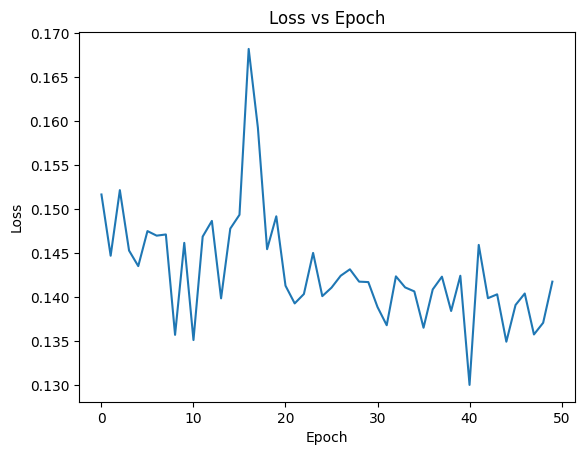

In [109]:
#Instantiating the  BCEWithLogitsLoss and Adam Optimizer 
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
training(model, train_dataloader, criterion, optimizer, num_epochs=50)

In [104]:
# Testing Function
def testing(model, test_loader, criterion):
    """
    Tests the model on the test images and returns the mean Intersection over Union (IoU) score and Dice score.

    :param model: Trained model to be tested.
    :param test_loader: Data loader for test dataset.
    :param criterion: Loss function.
    :return: Mean IoU score and mean Dice score.
    """
    # Set model to evaluation mode and disable gradient computation
    model.eval()
    with torch.no_grad():
        # Initialize variables for calculating mean IoU score and mean Dice score
        iou_score = 0.0
        dice_score = 0.0
        num_images = 0

        # Iterate through the test data loader
        for images, masks in test_loader:
            # Transfer images and masks to device
            images = images.to(device)
            masks = masks.to(device)

            # Interpolate masks to the same size as the predicted outputs
            masks = torch.nn.functional.interpolate(masks, size=(128, 128), mode='bilinear', align_corners=False)

            # Generate predicted outputs from the model
            outputs = model(images)

            # Compute the batch IoU score and Dice score
            batch_iou_score = calculate_test_iou(outputs, masks)
            batch_dice_score = calculate_test_dice(outputs, masks)

            # Update the overall IoU score and Dice score
            iou_score += batch_iou_score
            dice_score += batch_dice_score

            # Update the number of images processed
            num_images += images.size(0)

        # Compute the mean IoU score and Dice score
        mean_iou_score = iou_score / len(test_loader)
        mean_dice_score = dice_score / num_images

        # Print the mean IoU score and Dice score
        print('IoU for Testing Set: {:.4f}%'.format(mean_iou_score * 100))
        print('Dice for Testing Set: {:.4f}%'.format(mean_dice_score * 100))

    # Set model back to training mode
    model.train()

    return mean_iou_score, mean_dice_score


In [76]:
# Define the file paths for test images and masks
test_img_dir = '/content/Test/Images'
test_mask_dir = '/content/Test/Masks'

# Create a LungDatasetLoader object for test data
test_dataset = LungDatasetLoader(test_img_dir, test_mask_dir, is_train=False, transform=test_transform)

# Create a data loader for test data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the length of test data loader
print(f"Number of batches in test data loader: {len(test_loader)}")


Number of batches in test data loader: 13


In [94]:
# function to calculate Iou
def calculate_test_iou(outputs: torch.Tensor, masks: torch.Tensor) -> float:
    """
    Calculate Intersection over Union (IoU) score for test data.
    Args:
        outputs (torch.Tensor): model predictions.
        masks (torch.Tensor): actual masks.
    Returns:
        float: IoU score.
    """
    outputs = outputs > 0.5
    outputs = outputs.float()

    # Resize masks to match the output of the model
    masks = torch.nn.functional.interpolate(masks, size=(outputs.size(2), outputs.size(3)), mode='bilinear', align_corners=False)

    intersection = torch.logical_and(outputs, masks).sum().float()
    union = torch.logical_or(outputs, masks).sum().float()

    iou_score = (intersection + 1e-15) / (union + 1e-15)
    return iou_score.item()


In [95]:
# Function to plot Iou Graph
def plot_iou(dataloader, model):
    iou_list = []
    for images, masks in dataloader:
        # Move data to device
        images = images.to(device)
        masks = masks.to(device)

        # Get model predictions
        outputs = model(images)

        # Calculate IoU score for batch
        iou_score = calculate_test_iou(outputs, masks)
        iou_list.append(iou_score)

    # Calculate average IoU score for entire dataset
    avg_iou = sum(iou_list) / len(iou_list)

    # Plot IoU metric
    plt.plot(iou_list)
    plt.title(f"Average IoU: {avg_iou:.4f}")
    plt.xlabel("Batch")
    plt.ylabel("IoU Score")
    plt.show()


In [23]:
# Function to calculate Dice Score
def calculate_test_dice(outputs: torch.Tensor, masks: torch.Tensor) -> float:
    """
    Calculate dice coefficient for test data.
    Args:
        outputs (torch.Tensor): model predictions.
        masks (torch.Tensor): actual masks.
    Returns:
        float: dice coefficient.
    """
    # Convert probability maps to binary masks using threshold
    outputs = outputs > 0.5
    outputs = outputs.float()
    
    # Calculate intersection and union of predicted and true masks
    intersection = torch.logical_and(outputs, masks).sum().float()
    union = torch.logical_or(outputs, masks).sum().float()
    
    # Calculate dice coefficient
    dice = 2 * ((intersection+ 1e-15) / (union+ 1e-15))
    return dice.item()


# 3.Evaluate your model using the test images

In [105]:
Iou_Score ,Dice_loss= testing(model, test_loader, criterion)


Mean IoU for Testing Set: 88.7364%
Mean Dice for Testing Set: 11.5357%


# 4. Your IoU score should be higher than 0.8

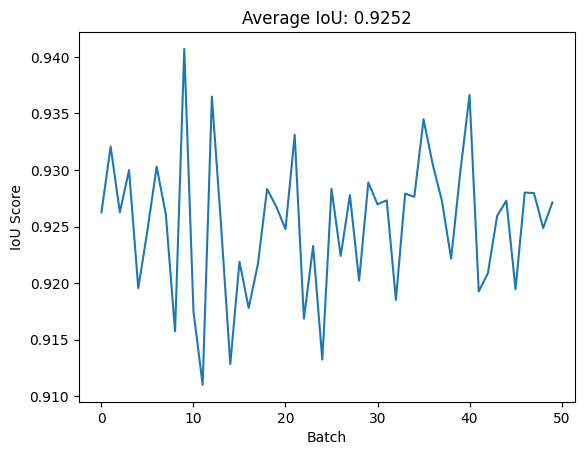

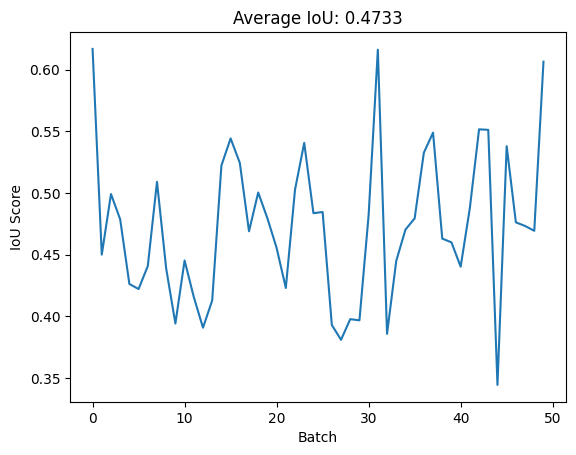

In [101]:
plot_iou(test_dataloader,model)
plot_iou(train_dataloader,model)

# 5. Write a 2-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


https://www.researchgate.net/publication/370527843_Lung_Segmentation_Model_using_UNet_Architecture_with_Resnet50_as_Backbone